In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM
from tensorflow.keras.callbacks import EarlyStopping

## Data Preparation

In [2]:
x = np.linspace(0,50,501)
y = np.sin(x)

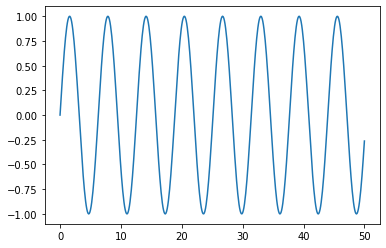

In [3]:
plt.plot(x,y)

In [4]:
df = pd.DataFrame(data=y,index=x,columns=['Sine'])
df

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


## Train and Test Data Preparation

In [5]:
test_percent = 0.1
test_point = np.round(len(df)*test_percent)
test_index = int(len(df)-test_point)

In [6]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [7]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [8]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [9]:
length = 50
batch_size = 1

generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length=length,batch_size=batch_size)

## Model

In [10]:
n_features = 1
model = Sequential()

model.add(SimpleRNN(50,input_shape=(length,n_features)))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50)                2600      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.fit_generator(generator,epochs=5)

Epoch 1/5
401/401 [==============================] - 28s 69ms/step - loss: 0.0111
Epoch 2/5
401/401 [==============================] - 28s 69ms/step - loss: 4.7676e-06
Epoch 3/5
401/401 [==============================] - 28s 69ms/step - loss: 4.4557e-05
Epoch 4/5
401/401 [==============================] - 26s 64ms/step - loss: 1.3142e-04
Epoch 5/5
401/401 [==============================] - 25s 62ms/step - loss: 1.2686e-04


In [13]:
loss = pd.DataFrame(model.history.history)

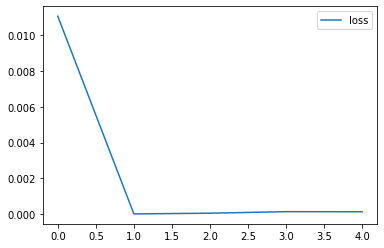

In [14]:
loss.plot()

In [15]:
first_eval_batch = scaled_train[-length:]
first_eval_batch = first_eval_batch.reshape((1,length,n_features))

In [16]:
model.predict(first_eval_batch)[0]

array([0.96533823], dtype=float32)

In [17]:
scaled_test[0]

array([0.94955134])

In [18]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    
    pred = model.predict(current_batch)[0]
    test_predictions.append(pred)
    current_batch = np.append(current_batch[:,1:,:],[[pred]],axis=1)

In [19]:
true_predictions = scaler.inverse_transform(test_predictions)

In [20]:
test['Predictions'] = true_predictions

C:\Users\sermengi\Anaconda3\envs\py3-TF2.0\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


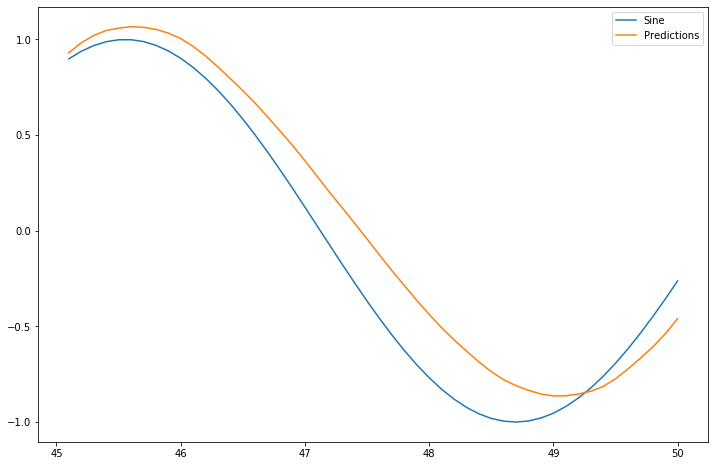

In [21]:
test.plot(figsize=(12,8))

## Model with Validation Earlystop

In [22]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [23]:
length = 49

generator = TimeseriesGenerator(scaled_train,scaled_train,
                                length=length,batch_size=1)

validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                           length=length,batch_size=1)

In [24]:
model = Sequential()

model.add(LSTM(50,input_shape=(length,n_features)))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit_generator(generator,callbacks=[early_stop],
                    validation_data=validation_generator,
                    epochs=20)

Epoch 1/20
402/402 [==============================] - 48s 121ms/step - loss: 0.0165 - val_loss: 6.5067e-05
Epoch 2/20
402/402 [==============================] - 48s 119ms/step - loss: 2.7295e-04 - val_loss: 4.6615e-05
Epoch 3/20
402/402 [==============================] - 51s 127ms/step - loss: 8.9407e-05 - val_loss: 1.8189e-05
Epoch 4/20
402/402 [==============================] - 44s 110ms/step - loss: 3.7948e-04 - val_loss: 7.6020e-05
Epoch 5/20
402/402 [==============================] - 46s 114ms/step - loss: 9.8735e-05 - val_loss: 7.0401e-07
Epoch 6/20
402/402 [==============================] - 44s 110ms/step - loss: 1.7968e-04 - val_loss: 3.2820e-05
Epoch 7/20
402/402 [==============================] - 44s 109ms/step - loss: 1.0773e-04 - val_loss: 2.0053e-05


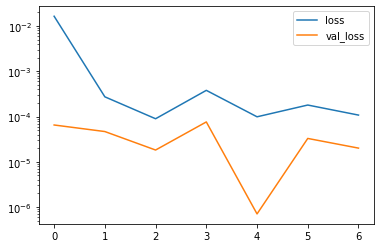

In [32]:
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.yscale('log')

In [38]:
def test_pred(train_df,size,n_features,length):

    test_predictions = []
    first_eval_batch = train_df[-length:]
    current_batch = first_eval_batch.reshape((1,length,n_features))

    for i in range(size):

        pred = model.predict(current_batch)[0]
        test_predictions.append(pred)
        current_batch = np.append(current_batch[:,1:,:],[[pred]],axis=1)
    
    return test_predictions

In [28]:
test_predictions = test_pred(scaled_train,len(test),n_features,length)
true_predictions = scaler.inverse_transform(test_predictions)

C:\Users\sermengi\Anaconda3\envs\py3-TF2.0\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


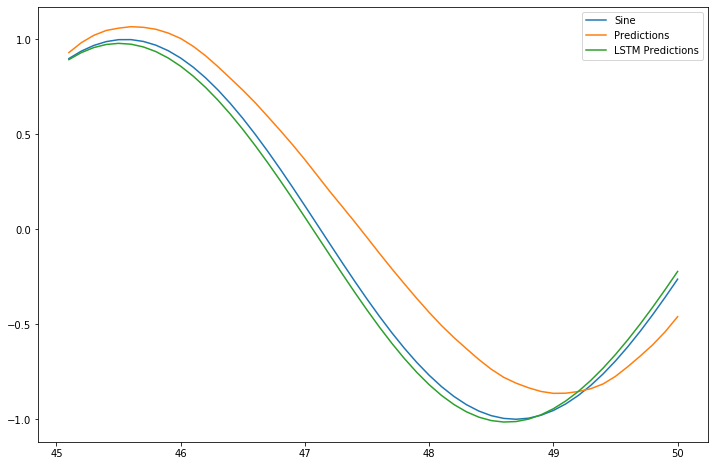

In [29]:
test['LSTM Predictions'] = true_predictions
test.plot(figsize=(12,8))

## Future Prediction

In [33]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [35]:
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,
                                length=length,batch_size=1)

In [36]:
model = Sequential()

model.add(LSTM(50,input_shape=(length,n_features)))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [37]:
model.fit_generator(generator,epochs=8)

Epoch 1/8
452/452 [==============================] - 53s 117ms/step - loss: 0.0189
Epoch 2/8
452/452 [==============================] - 54s 120ms/step - loss: 1.6285e-04
Epoch 3/8
452/452 [==============================] - 56s 125ms/step - loss: 2.5732e-04
Epoch 4/8
452/452 [==============================] - 50s 110ms/step - loss: 7.8265e-04
Epoch 5/8
452/452 [==============================] - 50s 111ms/step - loss: 4.8511e-05
Epoch 6/8
452/452 [==============================] - 54s 119ms/step - loss: 4.2476e-05
Epoch 7/8
452/452 [==============================] - 55s 121ms/step - loss: 1.4214e-04
Epoch 8/8
452/452 [==============================] - 56s 123ms/step - loss: 9.3283e-05


In [39]:
forecast = test_pred(scaled_train,25,n_features,length)
forecast = full_scaler.inverse_transform(forecast)
forecast_index = np.arange(50.1,52.6,step=.1)

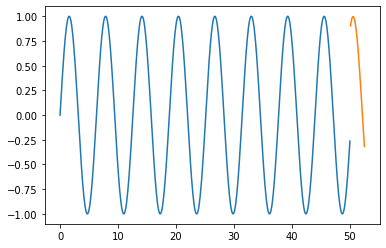

In [49]:
plt.plot(df.index,df['Sine'])
plt.plot(forecast_index,forecast)